# Data Processing and Loading

Note: This notebook combines the augmentation proposed in YoloV3 with pretrained data from Pseudo Labeling?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import re
import cv2
import imageio

from PIL import Image

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
godimg = 0

In [4]:
from utils import load_data, WheatDataset

# Set environment
ENV = 'gcloud' 

# Set data directory
if ENV == 'gcloud':
    DIR_INPUT = 'data'
elif ENV == 'kaggle':
    DIR_INPUT = '../input/global-wheat-detection'
else:
    print("Error: invalid environment specified")
    
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [5]:
# Load raw data
train_df, valid_df, test_df = load_data(DIR_INPUT, load = True)

In [6]:
# Augment datasets, inspired by CutMix and MixMatch
train_dataset = WheatDataset(dataframe = train_df, 
                             image_dir = DIR_TRAIN,
                             augment = True)

valid_dataset = WheatDataset(dataframe = valid_df, 
                             image_dir = DIR_TRAIN,
                             augment = False)

# Check a dataset sample
# print(train_dataset.__getitem__(1))

In [7]:
# Get data loaders
def collate_fn(batch): # collates a batch
    return tuple(zip(*batch))

train_data_loader = DataLoader(train_dataset, 
                               batch_size=16,
                               shuffle=True,
                               num_workers=0,
                               collate_fn=collate_fn)

valid_data_loader = DataLoader(valid_dataset, 
                               batch_size=8,
                               shuffle=True,
                               num_workers=0,
                               collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


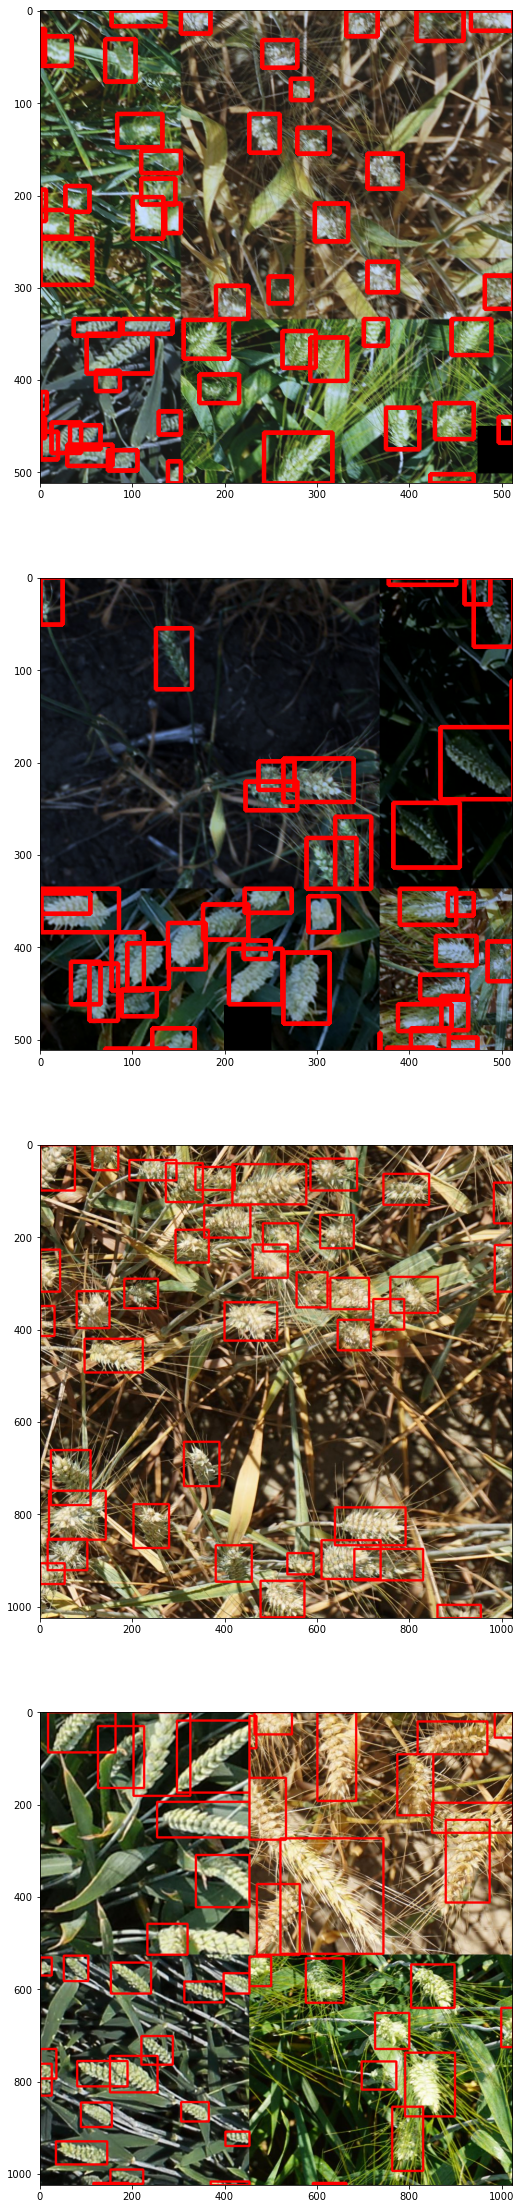

In [8]:
# Check data augmentation and loading
images, targets = next(iter(train_data_loader))
fig, ax = plt.subplots(4, 1, figsize=(80, 40))

for i in range(4):  
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()

    for box in boxes:
        cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])), 
                   220, 3)

    ax[i].imshow(sample)
plt.show()

# Model Training
We will be using pretrained pseudo labeling weights for better results.
<br>
<br>
We will be training for multiple epochs and saving the weights when the validation loss is the least. This will help us in getting the best weights file and avoid overfitting.

In [9]:
from utils import Averager

# Initialize the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=False)

# Set region of interest classifier
num_classes = 2  # output classes: wheat, background
in_features = model.roi_heads.box_predictor.cls_score.in_features # input features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace pre-trained

# Load model weights
WEIGHTS_FILE = "fasterrcnn_resnet50_fpn2nd.pth"
if ENV == 'kaggle':
    WEIGHTS_FILE = '../input/fork-of-fasterrcnn-pseudo-labeling/fasterrcnn_resnet50_fpn2nd.pth'
    
model.load_state_dict(torch.load(WEIGHTS_FILE))

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Choose optimizer, learning rates, epochs
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

num_epochs = 20 # Increase for better results

In [ ]:
# Training loop
folder = './imgaug-cutmix'
if not os.path.exists(folder):
    os.makedirs(folder)
    
loss_hist = Averager()
val_loss_hist = Averager()
itr = 1
least_loss = float('inf')

for epoch in range(num_epochs):
    loss_hist.reset()
    val_loss_hist.reset()
    
    # Train step
    for images, targets in train_data_loader:
        
        images_ = list(image.to(device) for image in images)
        targets_ = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images_, targets_)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # Validation Step
    for images, targets in valid_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        val_loss_dict = model(images, targets)

        val_losses = sum(loss for loss in val_loss_dict.values())
        val_loss_value = val_losses.item()

        val_loss_hist.send(val_loss_value)

    
    # Update best model or the learning rate
    if val_loss_hist.value < least_loss:
        least_loss = val_loss_hist.value
        lval=int(least_loss*1000)/1000
        torch.save(model.state_dict(), f'{folder}/fasterrcnn_custom_test_ep{epoch}_loss{lval}.pth')
        torch.save(model.state_dict(), f'{folder}/best_weights.pth')
        
    else:
        if lr_scheduler is not None:
            lr_scheduler.step()
    print(f"Epoch #{epoch} train_loss: {loss_hist.value} val_loss: {val_loss_hist.value}")

Iteration #50 loss: 0.7399212121963501
